In [1]:
#installing the libraries
#pip install geopy
#pip install pulp
#pip install networkx

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.point import Point
from pulp import *
import geopy.distance

In [3]:
#Reading the data
df=pd.read_csv('uber.csv')

In [4]:
#Displaying the data
df.head()

,Index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,35242813,09:47.0,22.5,2015-01-01 00:09:47 UTC,-73.990059,40.757221,-73.999512,40.723217,1
1,27835199,04:56.0,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,45:00.0,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,22:21.0,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,47:00.0,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
#Shape of the data
df.shape

(200000, 9)

In [6]:
#Filtering the dataset for Jan,2015
df=df[(df.pickup_datetime>='2015-01-01 00:00:00 UTC') & (df.pickup_datetime<='2015-01-31 00:00:00 UTC')]

In [7]:
#Creating pickup and dropoff coordinates
df['geom_pick'] = df.apply(lambda row: (str(row.pickup_latitude),str(row.pickup_longitude)),axis=1)
df['geom_drop'] = df.apply(lambda row: (str(row.dropoff_latitude),str(row.dropoff_longitude)),axis=1)

In [8]:
#Calulating distance in miles based on pick up and dropoff coordinates
df['distance'] = df.apply(lambda x: geopy.distance.distance(x.geom_drop,x.geom_pick).miles, axis=1)

In [10]:
#Extracting address from the coordinates(takes time to run)
geolocator = Nominatim(user_agent="geoapiExercises")
df['pickup_location'] = df.apply(lambda row: geolocator.reverse(row.geom_pick).address,axis=1)
df['drop_location'] = df.apply(lambda row: geolocator.reverse(row.geom_drop).address,axis=1)

In [11]:
#Standardising the pick up and drop
df['pick']=df['pickup_location'].str.split(",",-1,expand=True)[0]+df['pickup_location'].str.split(",",-1,expand=True)[1]+df['pickup_location'].str.split(",",-1,expand=True)[2]
df['dropoff']=df['drop_location'].str.split(",",-1,expand=True)[0]+df['drop_location'].str.split(",",-1,expand=True)[1]+df['drop_location'].str.split(",",-1,expand=True)[2]

In [12]:
df.head()

,Index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,geom_pick,geom_drop,distance,pickup_location,drop_location,pick,dropoff
0,35242813,09:47.0,22.5,2015-01-01 00:09:47 UTC,-73.990059,40.757221,-73.999512,40.723217,1,"(40.75722122, -73.9900589)","(40.72321701, -73.99951172)",2.398255,"Port Authority Bus Terminal, 625, 8th Avenue, ...","Alo Yoga, 96, Spring Street, Manhattan Communi...",Port Authority Bus Terminal 625 8th Avenue,Alo Yoga 96 Spring Street
10,51300077,15:31.0,9.5,2015-01-01 00:15:31 UTC,-73.985649,40.747444,-73.988586,40.729805,1,"(40.74744415, -73.98564911)","(40.72980499, -73.98858643)",1.226872,"320, 5th Avenue, Manhattan Community Board 5, ...","Barney Building, 227, East 9th Street, Manhatt...",320 5th Avenue Manhattan Community Board 5,Barney Building 227 East 9th Street
18,41247972,20:44.0,6.0,2015-01-01 00:20:44 UTC,-73.995056,40.765320,-73.974457,40.753860,1,"(40.76531982, -73.99505615)","(40.75386047, -73.97445679)",1.339188,"49 St Deli & Coffee House, 682, 11th Avenue, M...","Grand Central Terminal, Park Avenue, Manhattan...",49 St Deli & Coffee House 682 11th Avenue,Grand Central Terminal Park Avenue Manhattan C...
21,41138301,47:06.0,5.5,2015-01-01 00:47:06 UTC,-74.002419,40.733700,-73.987282,40.720634,2,"(40.7336998, -74.00241852)","(40.72063446, -73.9872818)",1.201727,"59, Christopher Street, Manhattan Community Bo...","147, Essex Street, Manhattan Community Board 3...",59 Christopher Street Manhattan Community Board 2,147 Essex Street Manhattan Community Board 3
47,13349674,51:07.0,6.0,2015-01-01 00:51:07 UTC,-73.985779,40.722897,-73.984879,40.760651,1,"(40.72289658, -73.98577881)","(40.76065063, -73.98487854)",2.605556,"20, Avenue A, Manhattan Community Board 3, Man...","Crowne Plaza Times Square, 1605, Broadway, Tim...",20 Avenue A Manhattan Community Board 3,Crowne Plaza Times Square 1605 Broadway


In [14]:
#Group by pickup and dropoff location
df_network=df.groupby(['pick','dropoff']).mean()[['distance','fare_amount']]
df_network.reset_index(inplace=True)

In [15]:
#Generating the graph from pandas dataset
G=nx.from_pandas_edgelist(df_network,source='pick',target='dropoff',edge_attr=['distance','fare_amount'],create_using=nx.DiGraph())

In [16]:
nx.info(G)

'DiGraph with 3257 nodes and 2069 edges'

In [27]:
#Creating Subgraph of the largest weakly connected components
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [28]:
#Number of Weakly Connected Components
len(Gcc)

1191

In [30]:
list(G0.nodes())

['340 East 34th Street Manhattan Community Board 6',
 '1126 Park Avenue Manhattan Community Board 8',
 'Citi Bike - Columbus Av / W 71 St Columbus Avenue Manhattan Community Board 7',
 '8th Avenue & West 31st Street West 31st Street Chelsea District',
 '68-06 Woodside Avenue Queens',
 'Papaya King 179 East 86th Street',
 '235 East 22nd Street Manhattan Community Board 6',
 '345 East 84th Street Manhattan Community Board 8',
 'USPS Park Avenue Manhattan Community Board 8',
 '46-15 Center Boulevard Long Island City',
 '655 Madison Avenue Manhattan Community Board 8',
 'East Tremont Avenue & Arthur Avenue East Tremont Avenue East Tremont',
 '385 Greenwich Street Manhattan Community Board 1',
 'East Houston Street & Greene Street West Houston Street Manhattan Community Board 2',
 'Madison Square Madison Avenue Manhattan Community Board 5',
 'Holiday Inn Express 538 West 48th Street',
 'Fulton Street Broadway Manhattan Community Board 1',
 '137 Hoyt Street Boerum Hill',
 'American Airlines 

In [20]:
#Number of Nodes in the largest Weakly Connected Component
G0.number_of_nodes()

224

In [21]:
#Number of Edges in the largest Weakly Connnected Component
G0.number_of_edges()

226

C:\Users\nilch\AppData\Local\Temp\ipykernel_85680\1707374378.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


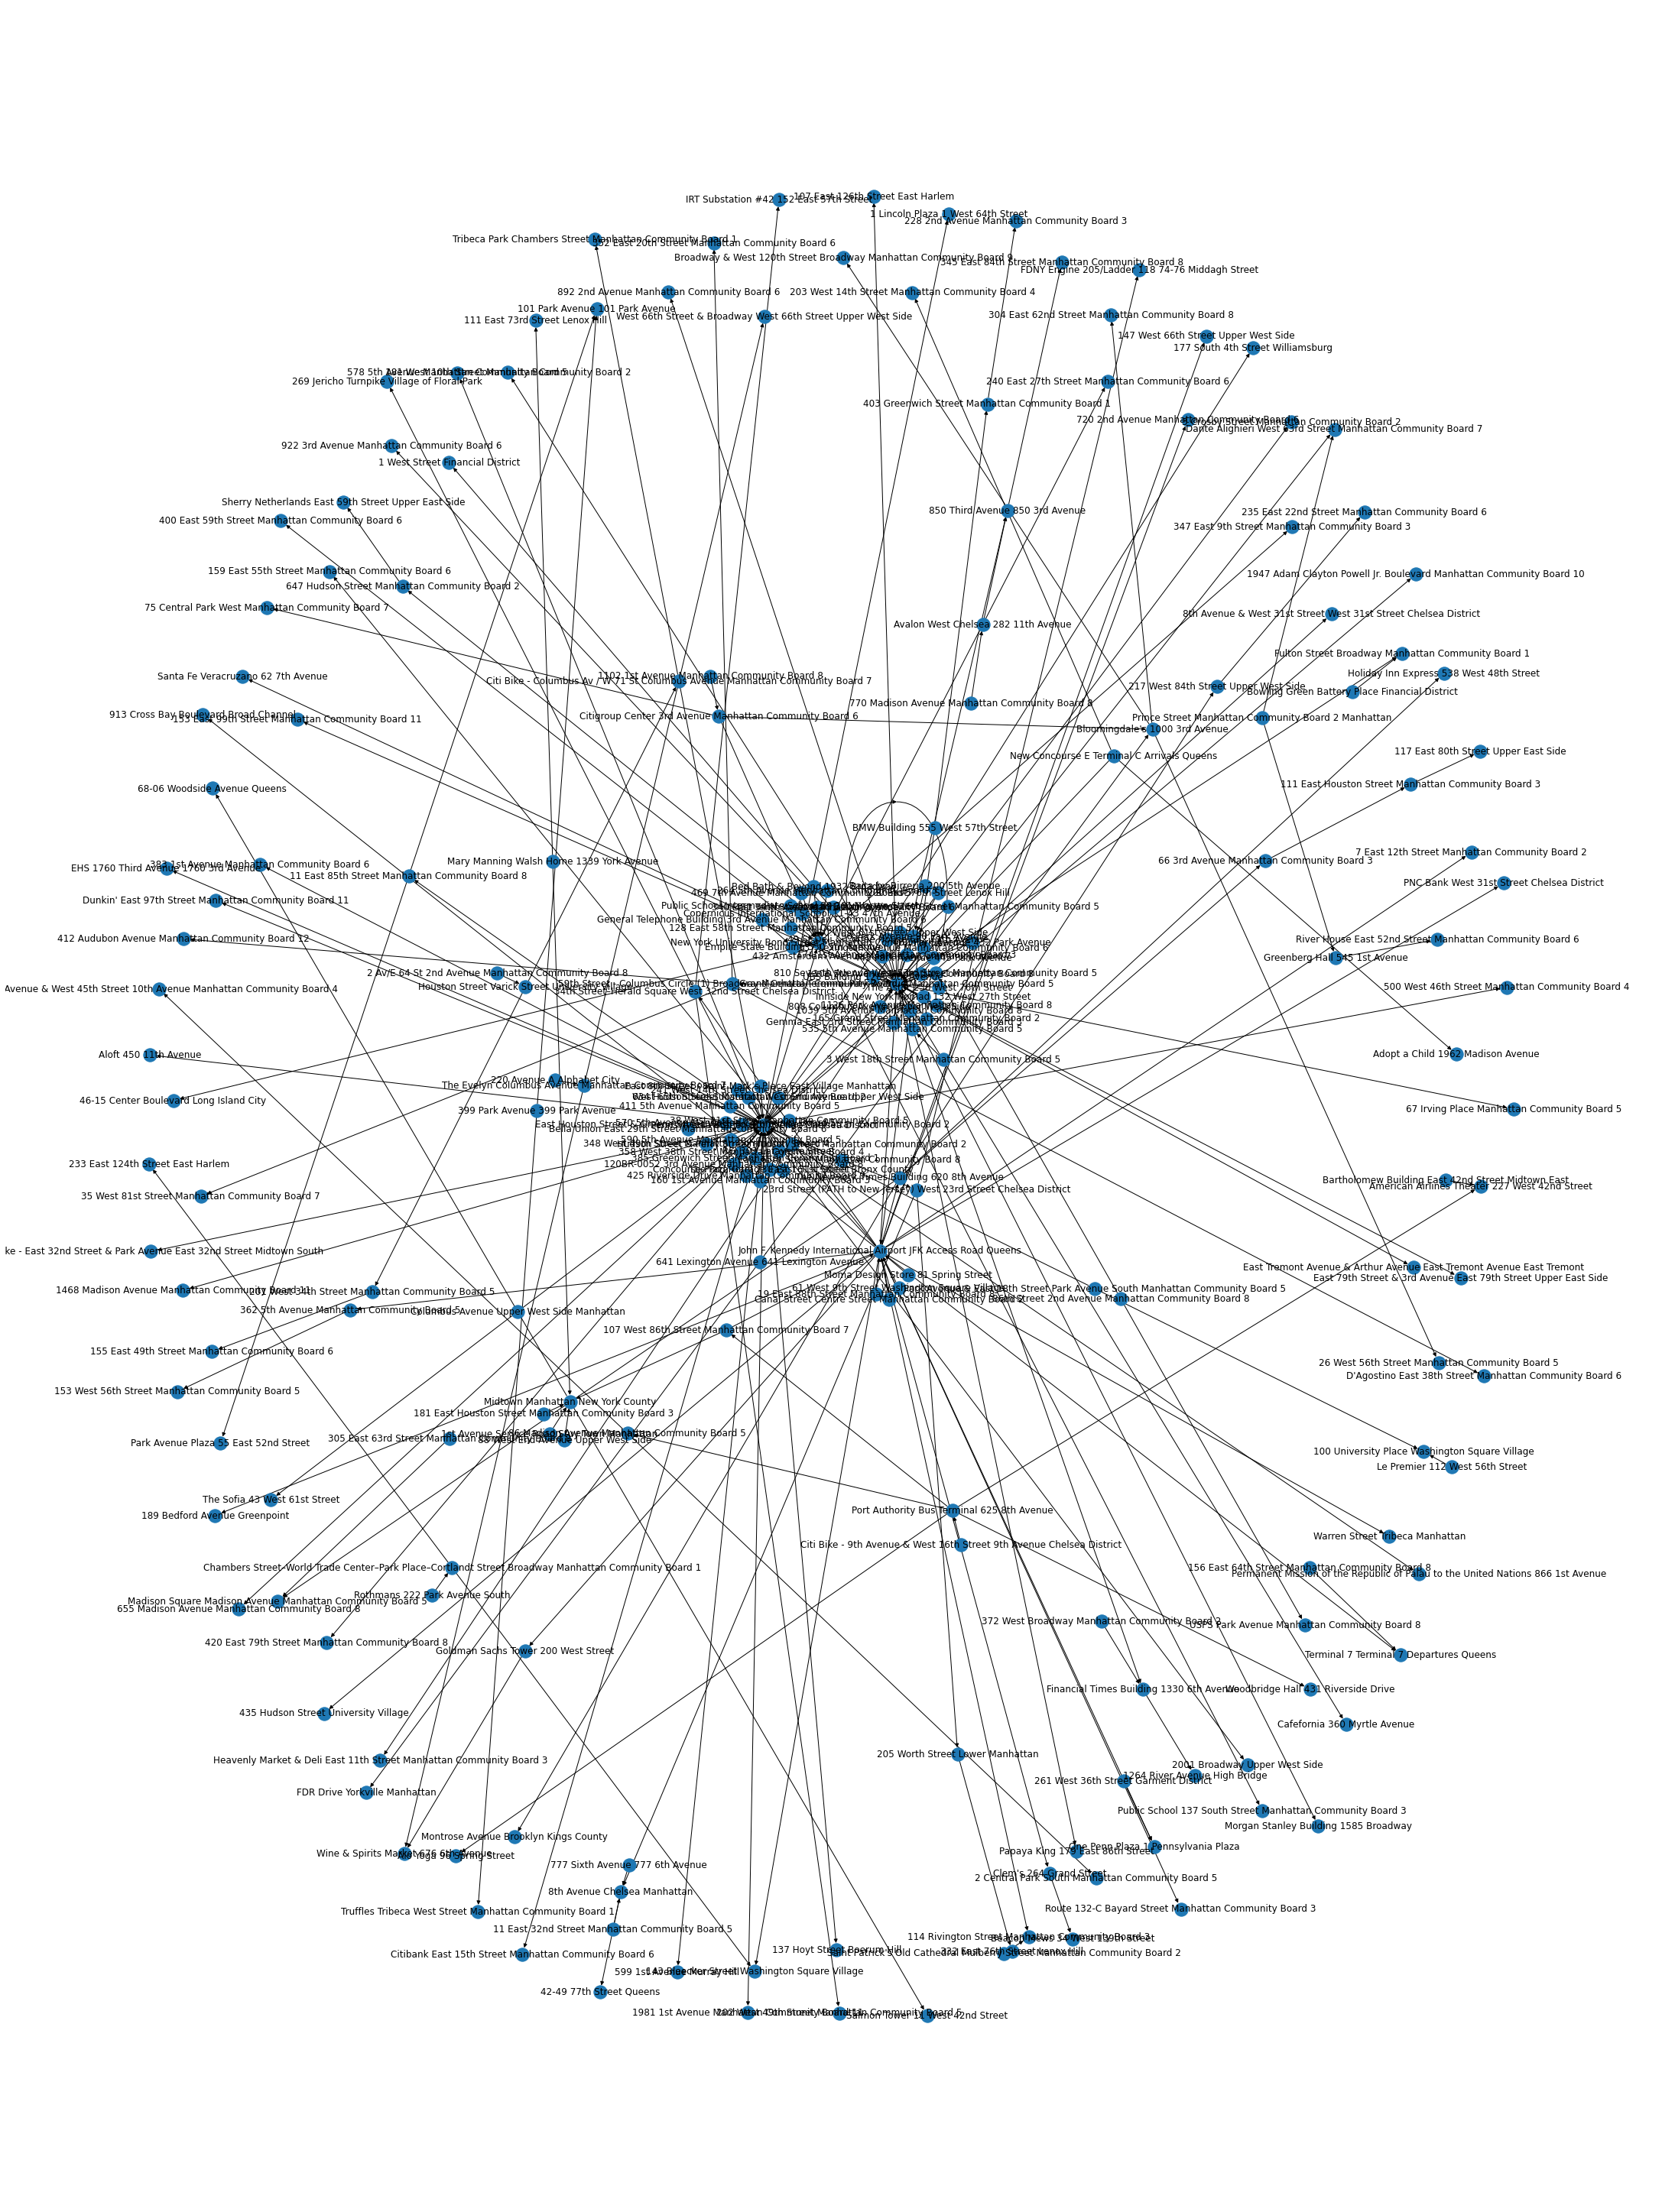

In [22]:
plt.figure(figsize=(30,40))
nx.draw(G0,with_labels=True)
plt.tight_layout()

In [31]:
#Neighbours of Grand Central Terminal, Park Avenue
list(G0.neighbors('Grand Central Terminal Park Avenue Manhattan Community Board 5'))

['1 West Street Financial District',
 '107 East 126th Street East Harlem',
 '153 East 99th Street Manhattan Community Board 11',
 '181 West 10th Street Manhattan Community Board 2',
 '59th Street - Columbus Circle (1) Broadway Manhattan Community Board 4',
 '647 Hudson Street Manhattan Community Board 2',
 '67 Irving Place Manhattan Community Board 5',
 '850 Third Avenue 850 3rd Avenue',
 '892 2nd Avenue Manhattan Community Board 6',
 '922 3rd Avenue Manhattan Community Board 6',
 'Cafefornia 360 Myrtle Avenue',
 'Dante Alighieri West 63rd Street Manhattan Community Board 7',
 'East 79th Street & 3rd Avenue East 79th Street Upper East Side',
 'East Tremont Avenue & Arthur Avenue East Tremont Avenue East Tremont',
 'Financial Times Building 1330 6th Avenue',
 'Fulton Street Broadway Manhattan Community Board 1',
 'Grand Central Terminal Park Avenue Manhattan Community Board 5',
 'Heavenly Market & Deli East 11th Street Manhattan Community Board 3',
 'Morgan Stanley Building 1585 Broadwa

In [42]:
#Minimum Vertex Cover
def MinimumVertexCover(G):
    
    prob=LpProblem("MinimuVertexcoversize",LpMinimize)
    
    a=LpVariable.dicts("X",G.nodes(),cat="Binary")
    b=LpVariable.dicts("Y",G.edges(),cat="Binary")
    
    
    #Constraints for each edge between the nodes in graph
    for (i,j) in G.edges(): 
        prob += a[i]+a[j]>=1     #Constraint for each edge there is a minimum one node touching it the vertex cover
        prob += b[(i,j)]<=a[j]   
        prob += b[(i,j)]<=1-a[i]
       
    
    #Objective function
    prob += lpSum(a)  #Minimizing the sum of all the vertex
    
    l=[]
    prob.solve()
    print("The minimum number of nodes to cover all the edges in the connected graphs is:",prob.objective.value())
    for v in prob.variables():
        if v.varValue==1:
            l.append(v.name)
    return l

In [46]:
#Minimum vertex cover of the largest connected component
l=MinimumVertexCover(G0)  #List to store all the nodes in the vertex cover
list_vertex_cover=[]
for i in range(len(l)):
    list_vertex_cover.append(l[i].replace("_"," ")[2:])
pd.Series(list_vertex_cover) #The list of locations that cover all the routes

The minimum number of nodes to cover all the edges in the connected graphs is: 52.0


0        100 University Place Washington Square Village
1                       111 East 73rd Street Lenox Hill
2     111 East Houston Street Manhattan Community Bo...
3       11 East 85th Street Manhattan Community Board 8
4      153 West 56th Street Manhattan Community Board 5
5      155 East 49th Street Manhattan Community Board 6
6      156 East 64th Street Manhattan Community Board 8
7      235 East 22nd Street Manhattan Community Board 6
8     23rd Street (PATH to New Jersey) West 23rd Str...
9                 261 West 36th Street Garment District
10     305 East 63rd Street Manhattan Community Board 8
11                      332 East 76th Street Lenox Hill
12     345 East 84th Street Manhattan Community Board 8
13     348 West 49th Street Manhattan Community Board 4
14    34th Street–Herald Square West 32nd Street Che...
15                      399 Park Avenue 399 Park Avenue
16     403 Greenwich Street Manhattan Community Board 1
17                      432 Park Avenue 432 Park

In [33]:
def BellmanFord(G,s,k): #k is the edge_weight- distance/fare_amount
    V=len(G)   #Number of Nodes present in G
    dist=dict(G.nodes) #Distance dictionary to return distance of each node from source node
    for i in dist:
        dist[i]=float(np.inf) # Initialising all the distance from source 's' as infinity
    dist[s]=0.0        
    dict_parents=dict(G.nodes) #Parent dictionary
    for (u,v) in list(G.edges): #Iterating over edges
        if dist[u] != float("Inf") and dist[v]>dist[u]+G[u][v][k]: #Checking if the initial distance is greater 
            dist[v]=dist[u]+G[u][v][k]
            dict_parents[v]=u  #Assigning the parents
        else:
            dict_parents[u]=None  
    #Checking for negative cycle     
    for (u,v) in list(G.edges):
        if dist[u] != float("Inf") and dist[v]>dist[u]+G[u][v][k]:
            dist[v]=np.inf 
                
    sorted_values = sorted(dist.values()) # Sort the values
    sorted_dict = {}

    for i in sorted_values:
        for j in dist.keys():
            if dist[j] == i:
                sorted_dict[j] = dist[j]
    df_bellman=pd.DataFrame(sorted_dict.keys(),sorted_dict.values()).reset_index()
    df_bellman.rename({'index':k,0:'dropoff_location'},axis=1,inplace=True)
    df_bellman=df_bellman[df_bellman[k]!=np.inf]
    
    return df_bellman

In [34]:
#Shortest path Based on distance(to find the minimum distance in miles)
BellmanFord(G0,'Grand Central Terminal Park Avenue Manhattan Community Board 5','distance')

,distance,dropoff_location
0,0.000000,Grand Central Terminal Park Avenue Manhattan C...
1,0.361334,850 Third Avenue 850 3rd Avenue
2,0.449345,892 2nd Avenue Manhattan Community Board 6
3,0.631652,Financial Times Building 1330 6th Avenue
4,0.632547,Morgan Stanley Building 1585 Broadway
5,0.677729,922 3rd Avenue Manhattan Community Board 6
6,1.150330,59th Street - Columbus Circle (1) Broadway Man...
7,1.271566,67 Irving Place Manhattan Community Board 5
8,1.320024,Dante Alighieri West 63rd Street Manhattan Com...
9,1.627706,East 79th Street & 3rd Avenue East 79th Street...


In [35]:
#Shortest path based on fare_amount(to determine the minimum fare for the trip)
BellmanFord(G0,'Grand Central Terminal Park Avenue Manhattan Community Board 5','fare_amount')

,fare_amount,dropoff_location
0,0.00,Grand Central Terminal Park Avenue Manhattan C...
1,4.50,Financial Times Building 1330 6th Avenue
2,5.00,Santa Fe Veracruzano 62 7th Avenue
3,6.00,Cafefornia 360 Myrtle Avenue
4,6.50,922 3rd Avenue Manhattan Community Board 6
5,6.50,Dante Alighieri West 63rd Street Manhattan Com...
6,7.00,East Tremont Avenue & Arthur Avenue East Tremo...
7,8.50,Fulton Street Broadway Manhattan Community Boa...
8,8.50,647 Hudson Street Manhattan Community Board 2
9,9.00,Heavenly Market & Deli East 11th Street Manhat...


In [39]:
#Merging the two dataset
df_distance_fare_grand_central=pd.merge(right=BellmanFord(G0, 'Grand Central Terminal Park Avenue Manhattan Community Board 5','fare_amount'),left=BellmanFord(G0,'Grand Central Terminal Park Avenue Manhattan Community Board 5','distance'),how='left',on='dropoff_location')

In [40]:
#Creating fare_per_mile column
df_distance_fare_grand_central['fare_per_mile']=df_distance_fare_grand_central['fare_amount']/df_distance_fare_grand_central['distance']

In [41]:
#Final Result
df_distance_fare_grand_central.sort_values(by='fare_per_mile',ascending=False).dropna()

,distance,dropoff_location,fare_amount,fare_per_mile
2,0.449345,892 2nd Avenue Manhattan Community Board 6,17.00,37.832819
4,0.632547,Morgan Stanley Building 1585 Broadway,22.66,35.823412
1,0.361334,850 Third Avenue 850 3rd Avenue,10.00,27.675256
7,1.271566,67 Irving Place Manhattan Community Board 5,17.50,13.762559
5,0.677729,922 3rd Avenue Manhattan Community Board 6,6.50,9.590847
6,1.150330,59th Street - Columbus Circle (1) Broadway Man...,10.50,9.127816
12,1.847338,Papaya King 179 East 86th Street,15.50,8.390452
13,2.008945,181 West 10th Street Manhattan Community Board 2,14.50,7.217719
3,0.631652,Financial Times Building 1330 6th Avenue,4.50,7.124174
9,1.627706,East 79th Street & 3rd Avenue East 79th Street...,10.00,6.143614
